## Explore data

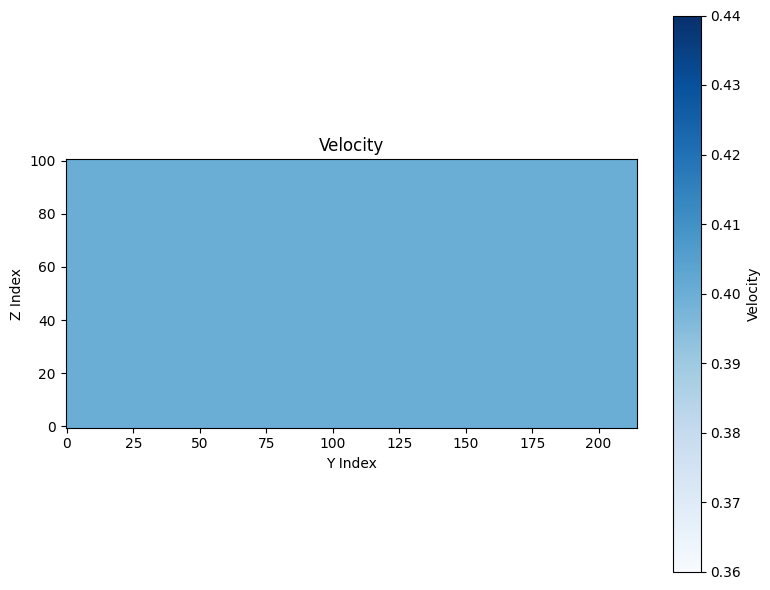

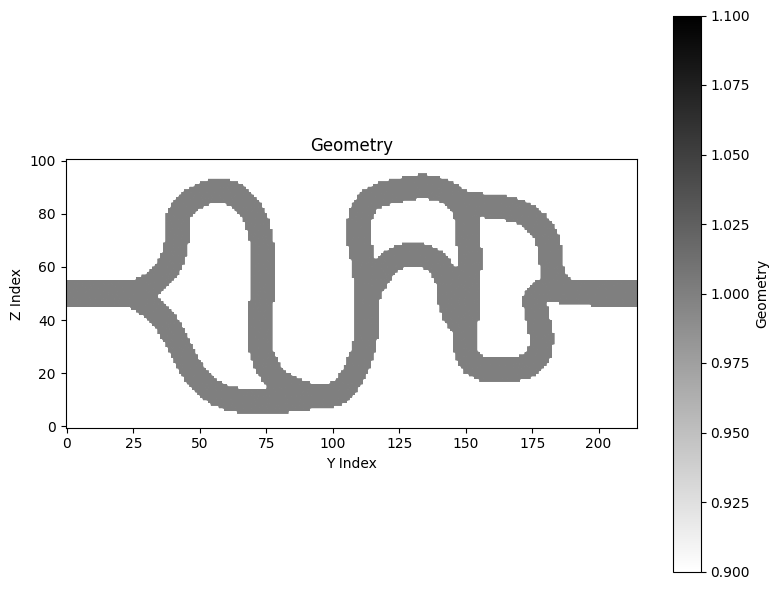

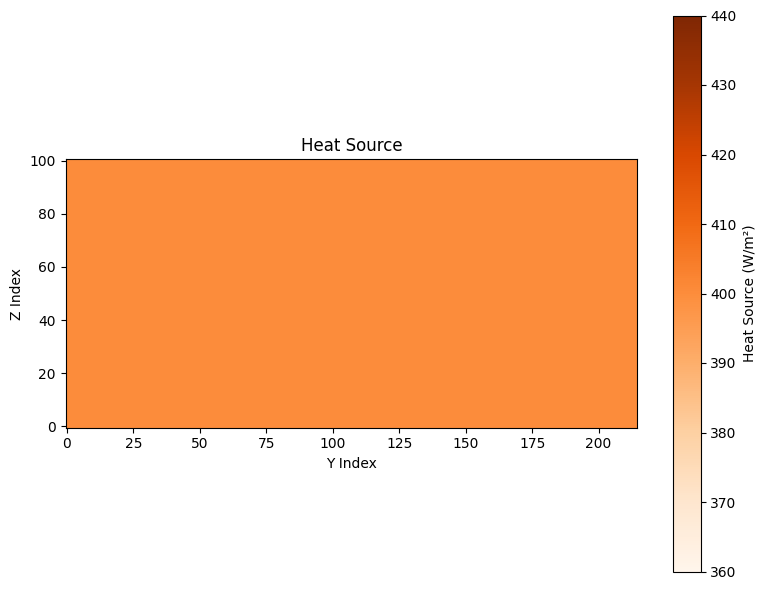

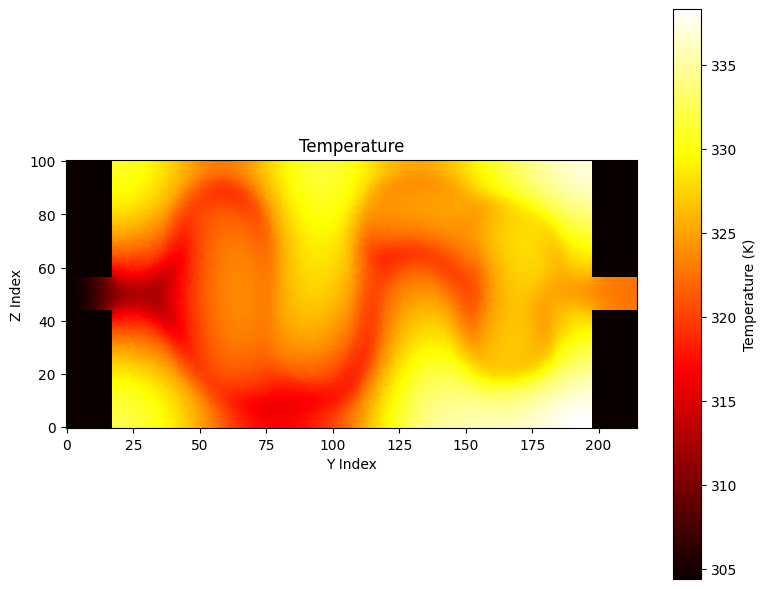

Pressure Drop for sample '0028': 427.5818614740128 Pa


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_FOLDER = '400Samples'
MATRIX_ROWS = 101
MATRIX_COLS = 215

def get_sample_files(sample_index, base_folder=BASE_FOLDER):
    files = [f for f in os.listdir(base_folder) if f.startswith(sample_index + '_') and f.endswith('.csv')]
    deltap_file = next((os.path.join(base_folder, f) for f in files if 'deltap' in f.lower()), None)
    geom_file = next((os.path.join(base_folder, f) for f in files if 'geom' in f.lower()), None)
    temp_file = next((os.path.join(base_folder, f) for f in files if 'temp' in f.lower() or 'temperature' in f.lower()), None)
    if not all([deltap_file, geom_file, temp_file]):
        raise FileNotFoundError(f"One or more CSV files missing for sample '{sample_index}'.")
    return {'deltap': deltap_file, 'geom': geom_file, 'temp': temp_file}

def parse_filename(filename):
    base = os.path.splitext(filename)[0]
    parts = base.split('_')
    heat_source = float(parts[-2])
    velocity = float(parts[-1])
    return heat_source, velocity

def load_pressure_drop(deltap_csv):
    df = pd.read_csv(deltap_csv)
    if df.empty:
        raise ValueError(f"Deltap CSV '{deltap_csv}' is empty.")
    return df.iloc[0, 0]

def load_geometry(geom_csv):
    df = pd.read_csv(geom_csv, usecols=['Density (kg/m^3)', 'Y (m)', 'Z (m)'])
    df['Y (m)'] = df['Y (m)'].round(10)
    df['Z (m)'] = df['Z (m)'].round(10)
    df['Geometry'] = np.where(df['Density (kg/m^3)'] < 1500, 1, 0)
    pivot = df.pivot_table(index='Z (m)', columns='Y (m)', values='Geometry', fill_value=0)
    matrix = pivot.values
    if matrix.shape != (MATRIX_ROWS, MATRIX_COLS):
        matrix = np.pad(matrix, 
                        ((0, max(0, MATRIX_ROWS - matrix.shape[0])), 
                         (0, max(0, MATRIX_COLS - matrix.shape[1]))), 
                        'constant', constant_values=0)
        matrix = matrix[:MATRIX_ROWS, :MATRIX_COLS]
    return matrix

def load_temperature(temp_csv):
    df = pd.read_csv(temp_csv, usecols=['Temperature (K)', 'Y (m)', 'Z (m)'])
    df['Y (m)'] = df['Y (m)'].round(10)
    df['Z (m)'] = df['Z (m)'].round(10)
    pivot = df.pivot_table(index='Z (m)', columns='Y (m)', values='Temperature (K)', fill_value=0)
    matrix = pivot.values
    if matrix.shape != (MATRIX_ROWS, MATRIX_COLS):
        matrix = np.pad(matrix, 
                        ((0, max(0, MATRIX_ROWS - matrix.shape[0])), 
                         (0, max(0, MATRIX_COLS - matrix.shape[1]))), 
                        'constant', constant_values=0)
        matrix = matrix[:MATRIX_ROWS, :MATRIX_COLS]
    return matrix

def create_constant_matrix(value, rows=MATRIX_ROWS, cols=MATRIX_COLS):
    return np.full((rows, cols), value)

def plot_matrix(matrix, title, cmap='viridis', label='Value'):
    plt.figure(figsize=(8, 6))
    if np.any(matrix > 0):
        vmin = np.min(matrix[matrix > 0])
        vmax = np.max(matrix)
        plt.imshow(matrix, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.imshow(matrix, origin='lower', cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel('Y Index')
    plt.ylabel('Z Index')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def process_sample(sample_index, base_folder=BASE_FOLDER):
    files = get_sample_files(sample_index, base_folder)
    sample_filename = os.path.basename(files['geom'])
    heat_source, velocity = parse_filename(sample_filename)
    pressure_drop = load_pressure_drop(files['deltap'])
    geometry_matrix = load_geometry(files['geom'])
    temperature_matrix = load_temperature(files['temp'])
    velocity_matrix = create_constant_matrix(velocity)
    heat_source_matrix = create_constant_matrix(heat_source)
    plot_matrix(velocity_matrix, 'Velocity', cmap='Blues', label='Velocity')
    plot_matrix(geometry_matrix, 'Geometry', cmap='binary', label='Geometry')
    plot_matrix(heat_source_matrix, 'Heat Source', cmap='Oranges', label='Heat Source (W/m²)')
    plot_matrix(temperature_matrix, 'Temperature', cmap='hot', label='Temperature (K)')
    print(f"Pressure Drop for sample '{sample_index}': {pressure_drop} Pa")

sample_index = '0028'
process_sample(sample_index)


## Saving torch tensors

In [5]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

BASE_FOLDER = '400Samples'
MATRIX_ROWS = 101
MATRIX_COLS = 215

def get_sample_files(sample_index, base_folder=BASE_FOLDER):
    files = [f for f in os.listdir(base_folder) if f.startswith(sample_index + '_') and f.endswith('.csv')]
    deltap_file = next((os.path.join(base_folder, f) for f in files if 'deltap' in f.lower()), None)
    geom_file = next((os.path.join(base_folder, f) for f in files if 'geom' in f.lower()), None)
    temp_file = next((os.path.join(base_folder, f) for f in files if 'temp' in f.lower() or 'temperature' in f.lower()), None)
    if not all([deltap_file, geom_file, temp_file]):
        raise FileNotFoundError(f"One or more CSV files missing for sample '{sample_index}'.")
    return {'deltap': deltap_file, 'geom': geom_file, 'temp': temp_file}

def parse_filename(filename):
    base = os.path.splitext(filename)[0]
    parts = base.split('_')
    heat_source = float(parts[-2])
    velocity = float(parts[-1])
    return heat_source, velocity

def load_pressure_drop(deltap_csv):
    df = pd.read_csv(deltap_csv)
    if df.empty:
        raise ValueError(f"Deltap CSV '{deltap_csv}' is empty.")
    return df.iloc[0, 0]

def load_geometry(geom_csv):
    df = pd.read_csv(geom_csv, usecols=['Density (kg/m^3)', 'Y (m)', 'Z (m)'])
    df['Y (m)'] = df['Y (m)'].round(10)
    df['Z (m)'] = df['Z (m)'].round(10)
    df['Geometry'] = np.where(df['Density (kg/m^3)'] < 1500, 1, 0)
    pivot = df.pivot_table(index='Z (m)', columns='Y (m)', values='Geometry', fill_value=0)
    matrix = pivot.values
    if matrix.shape != (MATRIX_ROWS, MATRIX_COLS):
        matrix = np.pad(matrix, 
                        ((0, max(0, MATRIX_ROWS - matrix.shape[0])), 
                         (0, max(0, MATRIX_COLS - matrix.shape[1]))), 
                        'constant', constant_values=0)
        matrix = matrix[:MATRIX_ROWS, :MATRIX_COLS]
    return matrix

def load_temperature(temp_csv):
    df = pd.read_csv(temp_csv, usecols=['Temperature (K)', 'Y (m)', 'Z (m)'])
    df['Y (m)'] = df['Y (m)'].round(10)
    df['Z (m)'] = df['Z (m)'].round(10)
    pivot = df.pivot_table(index='Z (m)', columns='Y (m)', values='Temperature (K)', fill_value=0)
    matrix = pivot.values
    if matrix.shape != (MATRIX_ROWS, MATRIX_COLS):
        matrix = np.pad(matrix, 
                        ((0, max(0, MATRIX_ROWS - matrix.shape[0])), 
                         (0, max(0, MATRIX_COLS - matrix.shape[1]))), 
                        'constant', constant_values=0)
        matrix = matrix[:MATRIX_ROWS, :MATRIX_COLS]
    return matrix

def create_constant_matrix(value, rows=MATRIX_ROWS, cols=MATRIX_COLS):
    matrix = np.full((rows, cols), value)
    return matrix

def process_sample(sample_index):
    files = get_sample_files(sample_index)
    sample_filename = os.path.basename(files['geom'])
    heat_source, velocity = parse_filename(sample_filename)
    pressure_drop = load_pressure_drop(files['deltap'])
    geometry_matrix = load_geometry(files['geom'])
    temperature_matrix = load_temperature(files['temp'])
    velocity_matrix = create_constant_matrix(velocity)
    heat_source_matrix = create_constant_matrix(heat_source)
    return {
        'heat_source': heat_source_matrix,
        'channel_geometry': geometry_matrix,
        'pressure_drop': pressure_drop,
        'temperature': temperature_matrix,
        'inlet_velocity': velocity_matrix
    }

sample_files = [f for f in os.listdir(BASE_FOLDER) if f.endswith('.csv')]
sample_indices = sorted(list(set(f[:4] for f in sample_files)))

heat_sources = []
channel_geometries = []
pressure_drops = []
temperatures = []
inlet_velocities = []

for idx, sample_index in enumerate(sample_indices):
    try:
        data = process_sample(sample_index)
        heat_sources.append(data['heat_source'])
        channel_geometries.append(data['channel_geometry'])
        pressure_drops.append(data['pressure_drop'])
        temperatures.append(data['temperature'])
        inlet_velocities.append(data['inlet_velocity'])
        print(f"Processed sample {idx+1}/{len(sample_indices)}: {sample_index}")
    except Exception as e:
        print(f"Error processing sample '{sample_index}': {e}")

heat_sources = torch.tensor(heat_sources, dtype=torch.float32)
channel_geometries = torch.tensor(channel_geometries, dtype=torch.float32)
pressure_drops = torch.tensor(pressure_drops, dtype=torch.float32)
temperatures = torch.tensor(temperatures, dtype=torch.float32)
inlet_velocities = torch.tensor(inlet_velocities, dtype=torch.float32)

print("Heat Source tensor shape:", heat_sources.shape)
print("Channel Geometry tensor shape:", channel_geometries.shape)
print("Pressure Drop tensor shape:", pressure_drops.shape)
print("Temperature tensor shape:", temperatures.shape)
print("Inlet Velocity tensor shape:", inlet_velocities.shape)

train_indices, test_indices = train_test_split(range(len(sample_indices)), test_size=0.2, random_state=42)

train_data = {
    'heat_source': heat_sources[train_indices],
    'channel_geometry': channel_geometries[train_indices],
    'pressure_drop': pressure_drops[train_indices],
    'temperature': temperatures[train_indices],
    'inlet_velocity': inlet_velocities[train_indices]
}

test_data = {
    'heat_source': heat_sources[test_indices],
    'channel_geometry': channel_geometries[test_indices],
    'pressure_drop': pressure_drops[test_indices],
    'temperature': temperatures[test_indices],
    'inlet_velocity': inlet_velocities[test_indices]
}

torch.save(train_data, 'M1_training_data.pt')
torch.save(test_data, 'M1_testing_data.pt')

print(f"Total samples: {len(sample_indices)}")
print(f"Training samples: {len(train_indices)}")
print(f"Testing samples: {len(test_indices)}")


Processed sample 1/400: 0001
Processed sample 2/400: 0002
Processed sample 3/400: 0003
Processed sample 4/400: 0004
Processed sample 5/400: 0005
Processed sample 6/400: 0006
Processed sample 7/400: 0007
Processed sample 8/400: 0008
Processed sample 9/400: 0009
Processed sample 10/400: 0010
Processed sample 11/400: 0011
Processed sample 12/400: 0012
Processed sample 13/400: 0013
Processed sample 14/400: 0014
Processed sample 15/400: 0015
Processed sample 16/400: 0016
Processed sample 17/400: 0017
Processed sample 18/400: 0018
Processed sample 19/400: 0019
Processed sample 20/400: 0020
Processed sample 21/400: 0021
Processed sample 22/400: 0022
Processed sample 23/400: 0023
Processed sample 24/400: 0024
Processed sample 25/400: 0025
Processed sample 26/400: 0026
Processed sample 27/400: 0027
Processed sample 28/400: 0028
Processed sample 29/400: 0029
Processed sample 30/400: 0030
Processed sample 31/400: 0031
Processed sample 32/400: 0032
Processed sample 33/400: 0033
Processed sample 34

C:\Users\franc\AppData\Local\Temp\ipykernel_11560\3874053739.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  heat_sources = torch.tensor(heat_sources, dtype=torch.float32)


Heat Source tensor shape: torch.Size([400, 101, 215])
Channel Geometry tensor shape: torch.Size([400, 101, 215])
Pressure Drop tensor shape: torch.Size([400])
Temperature tensor shape: torch.Size([400, 101, 215])
Inlet Velocity tensor shape: torch.Size([400, 101, 215])
Total samples: 400
Training samples: 320
Testing samples: 80
